# supernode-features

The procedure of constructing supernode features of various kinds.

__Warning!__ Some procedures require 16 cores and up to 5 GB RAM.

Requires:
1. `data/supernodes/supernode_attributes.json`
2. `data/supernodes/edges_pspace.json`
3. `data/supernodes/supernodes.json`

Produces:
1. `data/features/infrastructure_features.json`
2. `data/features/graph_features.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
from itertools import chain, product
from multiprocessing import Pool

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt

from myutils.spatial import get_earth_distances
from myutils.stats import corrcoef
from myutils.json import save_json, load_json
from myutils.matplotlib import matplotlib_latex, matplotlib_seaborn_style

from ptn.parallel_centralities import betweenness_centrality_parallel, \
    shortest_path_lengths_parallel, closeness_centrality_parallel
from config import supernode_attributes_fpath, edges_pspace_fpath, supernodes_fpath, \
    infrastructure_features_fpath, graph_features_fpath

matplotlib_seaborn_style()
matplotlib_latex()

In [3]:
supernode_attributes = pd.read_json(supernode_attributes_fpath).set_index('id')

supernode_attributes.head(2)

,Housing,Shopping,Restaurant,Services,Medicine,Education,Tourism,Fitness centre,Car service,Office building,Administrative,Grocery store,Hotel,Industrial area,Banking,Book shop,Post office,Religion,Shopping centre,Theatre
id,,,,,,,,,,,,,,,,,,,,
0,141,149,74,43,46,21,14,33,5,5,8,13,3,2,27,13,4,0,0,0
1,111,114,108,42,51,33,41,13,6,9,18,6,13,6,7,9,4,7,1,0


In [4]:
edges = load_json(edges_pspace_fpath)

edges[:2]

[{'hops': 1,
  'distance': 23.271852922989886,
  'route': 10003,
  'weight': 5.454370584597977,
  'u': 0,
  'v': 6},
 {'hops': 1,
  'distance': 14.853275410680604,
  'route': 2871,
  'weight': 3.7706550821361207,
  'u': 0,
  'v': 8}]

In [5]:
pspace = nx.Graph()

for edge in edges:
    pspace.add_edge(
        edge['u'],
        edge['v'],
        weight=edge['weight'],
        distance=edge['distance'],
        route=edge['route']
    )

len(pspace), len(pspace.edges)

(3202, 118449)

In [6]:
supernodes = pd.read_json(supernodes_fpath).set_index('id')

supernodes.head(2)

,stops,diameter,types,lat,lon
id,,,,,
0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.85171,30.322415
1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.95021,30.287937


## Infrastructure features

In [7]:
infrastructure_features = supernode_attributes.copy()

In [8]:
total = infrastructure_features.sum(axis=1)

mask = (total > 0)
infrastructure_features[mask] = infrastructure_features[mask].divide(total[mask], axis=0)
infrastructure_features['total'] = total

infrastructure_features.head(2)

,Housing,Shopping,Restaurant,Services,Medicine,Education,Tourism,Fitness centre,Car service,Office building,...,Grocery store,Hotel,Industrial area,Banking,Book shop,Post office,Religion,Shopping centre,Theatre,total
id,,,,,,,,,,,,,,,,,,,,,
0,0.234609,0.247920,0.123128,0.071547,0.076539,0.034942,0.023295,0.054908,0.008319,0.008319,...,0.021631,0.004992,0.003328,0.044925,0.021631,0.006656,0.000000,0.000000,0.0,601
1,0.185309,0.190317,0.180301,0.070117,0.085142,0.055092,0.068447,0.021703,0.010017,0.015025,...,0.010017,0.021703,0.010017,0.011686,0.015025,0.006678,0.011686,0.001669,0.0,599


In [9]:
infrastructure_features.notna().all().all()

True

In [10]:
infrastructure_features_json = []

for _, row in infrastructure_features.reset_index().iterrows():
    row = row.to_dict()
    row['id'] = int(row['id'])
    infrastructure_features_json.append(row)

In [11]:
save_json(infrastructure_features_json, infrastructure_features_fpath)

In [12]:
infrastructure_features = pd.read_json(infrastructure_features_fpath, encoding='utf-8').set_index('id')

infrastructure_features.head(2)

,Housing,Shopping,Restaurant,Services,Medicine,Education,Tourism,Fitness centre,Car service,Office building,...,Grocery store,Hotel,Industrial area,Banking,Book shop,Post office,Religion,Shopping centre,Theatre,total
id,,,,,,,,,,,,,,,,,,,,,
0,0.234609,0.247920,0.123128,0.071547,0.076539,0.034942,0.023295,0.054908,0.008319,0.008319,...,0.021631,0.004992,0.003328,0.044925,0.021631,0.006656,0.000000,0.000000,0.0,601
1,0.185309,0.190317,0.180301,0.070117,0.085142,0.055092,0.068447,0.021703,0.010017,0.015025,...,0.010017,0.021703,0.010017,0.011686,0.015025,0.006678,0.011686,0.001669,0.0,599


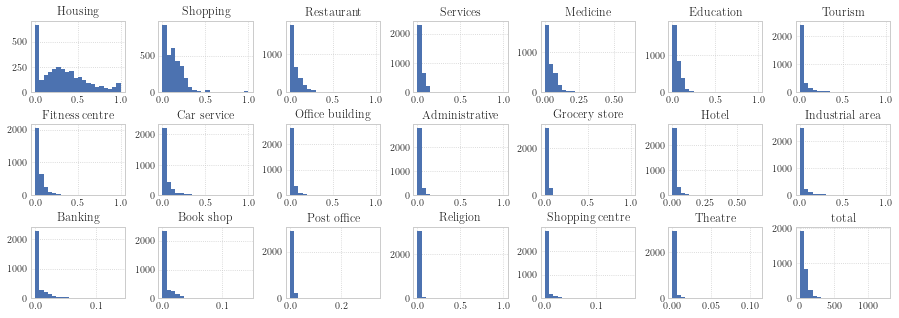

In [13]:
n_features = infrastructure_features.shape[1]

ncols = 7
nrows = n_features // ncols + int(n_features % ncols > 0)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(2.2 * ncols, 1.7 * nrows)
fig.subplots_adjust(wspace=0.35, hspace=0.45)
axes = axes.flatten()

for col, ax in zip(infrastructure_features.columns, axes):
    infrastructure_features[col].hist(ax=ax, bins=20)
    ax.set_title(col)
    
for i in range(n_features, len(axes)):
    axes[i].axis('off')
    
plt.savefig('../figures/infrastructure_feature_hists.pdf', transparent=True, bbox_inches='tight')

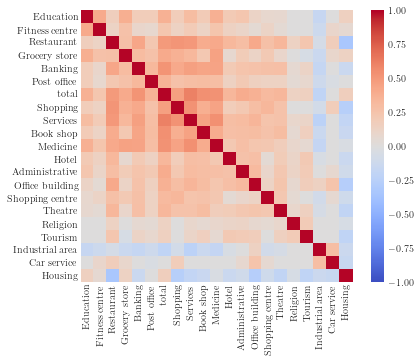

In [14]:
plt.figure(figsize=(6.5, 5))

corr = corrcoef(infrastructure_features, method='spearman').fillna(0)

sns.heatmap(corr, vmin=-1, cmap='coolwarm', square=True)

plt.savefig('../figures/infrastructure_features_corr.pdf', transparent=True, bbox_inches='tight')

In [15]:
total = infrastructure_features['total']

total.head(2)

id
0    601
1    599
Name: total, dtype: int64

In [16]:
quantiles = total.quantile([0, 0.3, 0.5, 0.8, 1]).astype(int)
quantiles

0.0       0
0.3      25
0.5      48
0.8     103
1.0    1254
Name: total, dtype: int64

In [17]:
def assign_size_cluster(value: float) -> str:
    for i, q in enumerate(quantiles):
        if value <= q:
            return i

size_clusters = total.apply(assign_size_cluster)

size_clusters.head(2)

id
0    4
1    4
Name: total, dtype: int64

In [18]:
coords = supernodes[['lon', 'lat']].values

coords

array([[30.3224152 , 59.85170995],
       [30.28793738, 59.95020979],
       [30.35401882, 59.95671589],
       ...,
       [30.3595223 , 59.9445053 ],
       [30.2344264 , 59.94853172],
       [30.21190075, 59.97198015]])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


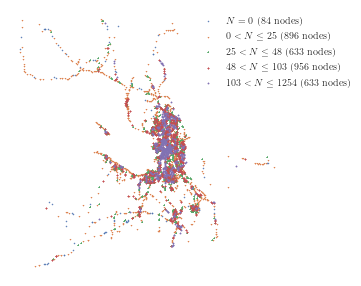

In [19]:
plt.figure(figsize=(5, 5))
plt.axis('off')

markers = ['.', '2', '+', 'x', '*']

for i in sorted(size_clusters.unique()):
    mask = (size_clusters == i)
    
    cluster_size = mask.sum()
    cluster_coords = coords[mask]
    cluster_marker = markers[i]
    
    if i == 0:
        label = f'$N = {quantiles.iloc[i]}$ ({cluster_size} nodes)'
    else:
        label = f'${quantiles.iloc[i - 1]} < N \\leq {quantiles.iloc[i]}$ ({cluster_size} nodes)'
        
    plt.scatter(*cluster_coords.T, color=f'C{i}', marker=cluster_marker, s=1, label=label)

plt.legend(loc='upper left', bbox_to_anchor=(0.65, 1))
# plt.title('Nodes with different number of attached infrastructure objects')

plt.savefig('../figures/number_infrastructure_objects.png', dpi=250, transparent=True, bbox_inches='tight')

## Graph features

In [20]:
connected_components = sorted(nx.connected_components(pspace), key=len)

[len(c) for c in connected_components]

[8, 9, 3185]

In [21]:
disconnected_nodes = connected_components[0].union(connected_components[1])

print(disconnected_nodes)

{2916, 2917, 1807, 1808, 2033, 2034, 2035, 2036, 2037, 2038, 3090, 3091, 1809, 1810, 1811, 1812, 1813}


In [22]:
connected = pd.Series({
    node: int(node not in disconnected_nodes)
    for node in pspace
})

connected.value_counts()

1    3185
0      17
dtype: int64

In [23]:
degree_centrality = pd.Series(nx.degree_centrality(pspace))

# degree_centrality.hist(bins=25)

In [24]:
%%time

betweenness_centrality = pd.Series(betweenness_centrality_parallel(pspace, weight='weight'))

# betweenness_centrality.hist(bins=25)

CPU times: user 2.87 s, sys: 347 ms, total: 3.22 s
Wall time: 37.2 s


In [25]:
%%time

shortest_path_lengths = pd.DataFrame(shortest_path_lengths_parallel(pspace, weight='weight'))
closeness_centrality_weight = closeness_centrality_parallel(shortest_path_lengths.T)

# closeness_centrality_weight.hist(bins=25)

CPU times: user 6.02 s, sys: 1.1 s, total: 7.12 s
Wall time: 33.6 s


In [26]:
%%time

shortest_path_lengths = pd.DataFrame(shortest_path_lengths_parallel(pspace, weight=None))
closeness_centrality_hops = closeness_centrality_parallel(shortest_path_lengths.T)

# closeness_centrality_hops.hist(bins=25)

CPU times: user 6.87 s, sys: 887 ms, total: 7.75 s
Wall time: 25.9 s


In [28]:
clustering = pd.Series(nx.clustering(pspace))

# clustering.hist(bins=25)

In [29]:
pagerank = pd.Series(nx.pagerank(pspace, weight=None))

# pagerank.hist(bins=25)

In [40]:
graph_features = pd.DataFrame({
    'is connected': connected,
    'Betweenness centrality': betweenness_centrality,
    'Closeness centrality (hops)': closeness_centrality_hops,
    # 'Closeness centrality (distance)': closeness_centrality_distance,
    'Closeness centrality (weight)': closeness_centrality_weight,
    'Degree centrality': degree_centrality,
    'PageRank': pagerank,
    'Clustering': clustering,
    # 'Eigenvector centrality': eigenvector_centrality,
})

graph_features.index.name = 'id'

graph_features.head(2)

,is connected,Betweenness centrality,Closeness centrality (hops),Closeness centrality (weight),Degree centrality,PageRank,Clustering
id,,,,,,,
0,1,0.097346,0.455434,0.159565,0.124024,0.001454,0.164644
1,1,0.011445,0.401304,0.157524,0.078101,0.000826,0.254800


In [41]:
graph_features.notna().all().all()

True

In [42]:
graph_features_json = []

for i, row in graph_features[sorted(graph_features.columns)].iterrows():
    item = {'id': i}
    item.update(row.to_dict())
    
    graph_features_json.append(item)
    
graph_features_json[0]

{'id': 0,
 'Betweenness centrality': 0.09734630083939548,
 'Closeness centrality (hops)': 0.45543432330833483,
 'Closeness centrality (weight)': 0.1595647990670011,
 'Clustering': 0.1646439203114266,
 'Degree centrality': 0.1240237425804436,
 'PageRank': 0.0014543681525720465,
 'is connected': 1.0}

In [43]:
save_json(graph_features_json, graph_features_fpath)

In [44]:
graph_features = pd.read_json(graph_features_fpath, encoding='utf-8').set_index('id')

graph_features.head(2)

,Betweenness centrality,Closeness centrality (hops),Closeness centrality (weight),Clustering,Degree centrality,PageRank,is connected
id,,,,,,,
0,0.097346,0.455434,0.159565,0.164644,0.124024,0.001454,1
1,0.011445,0.401304,0.157524,0.254800,0.078101,0.000826,1


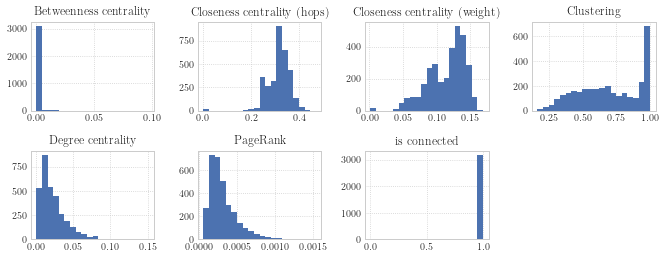

In [45]:
n_features = graph_features.shape[1]

ncols = 4
nrows = n_features // ncols + int(n_features % ncols > 0)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(2.8 * ncols, 2 * nrows)
fig.subplots_adjust(wspace=0.35, hspace=0.45)
axes = axes.flatten()

for col, ax in zip(graph_features.columns, axes):
    graph_features[col].hist(ax=ax, bins=20)
    ax.set_title(col)
    
for i in range(n_features, len(axes)):
    axes[i].axis('off')
    
plt.savefig('../figures/graph_feature_hists.pdf', transparent=True, bbox_inches='tight')

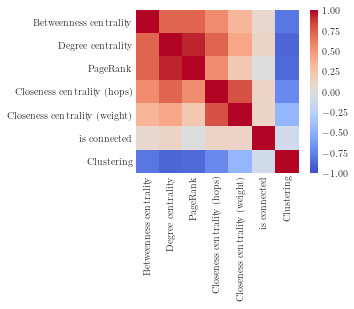

In [46]:
plt.figure(figsize=(4, 3))

corr = corrcoef(graph_features, method='spearman').fillna(0)

sns.heatmap(corr, square=True, vmin=-1, cmap='coolwarm')

plt.savefig('../figures/graph_features_corr.pdf', transparent=True, bbox_inches='tight')

In [47]:
infrastructure_features = pd.read_json(infrastructure_features_fpath, encoding='utf-8').set_index('id')
graph_features = pd.read_json(graph_features_fpath, encoding='utf-8').set_index('id')

In [48]:
all_features = pd.concat([infrastructure_features, graph_features], axis=1)\
    .drop(columns=['is connected', 'total'])

all_features.head(2)

,Housing,Shopping,Restaurant,Services,Medicine,Education,Tourism,Fitness centre,Car service,Office building,...,Post office,Religion,Shopping centre,Theatre,Betweenness centrality,Closeness centrality (hops),Closeness centrality (weight),Clustering,Degree centrality,PageRank
id,,,,,,,,,,,,,,,,,,,,,
0,0.234609,0.247920,0.123128,0.071547,0.076539,0.034942,0.023295,0.054908,0.008319,0.008319,...,0.006656,0.000000,0.000000,0.0,0.097346,0.455434,0.159565,0.164644,0.124024,0.001454
1,0.185309,0.190317,0.180301,0.070117,0.085142,0.055092,0.068447,0.021703,0.010017,0.015025,...,0.006678,0.011686,0.001669,0.0,0.011445,0.401304,0.157524,0.254800,0.078101,0.000826


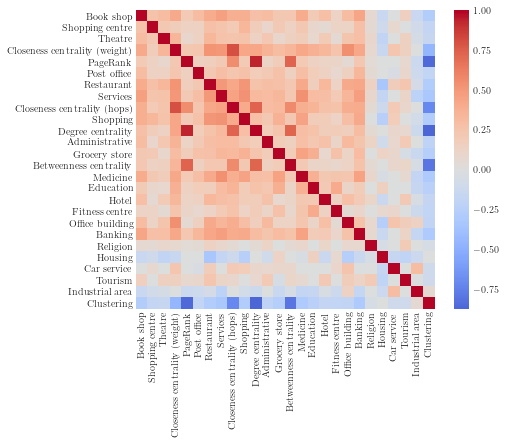

In [49]:
corr = corrcoef(all_features, method='spearman').fillna(0)

plt.figure(figsize=(7, 5.5))

sns.heatmap(corr, square=True, center=0, cmap='coolwarm')

plt.savefig('../figures/all_features_corr.pdf', transparent=True, bbox_inches='tight')